In [22]:
# dependecies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ETS
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import meanabs

In [23]:
# filepath
path_1 = "Data/BicycleSales_2015-20211021_Cleaned.xlsx"
path_2 = "Data/BikeSpecs.xlsx"

# read data
sales_df = pd.read_excel(path_1)
specs_df = pd.read_excel(path_2)

In [24]:
# rename specs Object column to Material
specs1_df = specs_df.rename(columns={"Object":"Material"})

# merge specs into sales data frame
merged_df = pd.merge(sales_df, specs1_df, on="Material", how="left")

In [25]:
# reduce down to necessary columns
reduced_df = merged_df[["Material", "Sold-to pt", "Month", "Invoiced Quantity", 
                        "Product hierarchy.1", "Application_x", "Tire Size", "Ply Construction",
                        "Bead", "Color", "TPI - Threads per inch", "Compound", "Technology"
                       ]]

# rename columns
reduced_df = reduced_df.rename(columns={"Product hierarchy.1":"Product hierarchy",
                                        "Application_x":"Application"})

# split tire size by diameter (before x) and width (after x)
reduced_df[["Diameter", "Width"]] = reduced_df["Tire Size"].str.split("X", n=1, expand=True)

# splite Month into separate month and year components
reduced_df[["Month", "Year"]] = reduced_df["Month"].str.split("/", n=1, expand=True)

# create Date column with reordered Year/Date format
reduced_df["Date"] = reduced_df["Year"] + "/" + reduced_df["Month"]

# strip erroneous text from diameter and width
reduced_df["Diameter"] = reduced_df["Diameter"].str.replace(r'"','')
reduced_df["Width"] = reduced_df["Width"].str.replace(r'"','')

# drop application Tubes and MVS
reduced_df = reduced_df[reduced_df["Application"].str.contains("TUBE|MVS")==False]

#Displaying Cleaned Dataframe
reduced_df

# Output to excel for review
# reduced_df.to_excel('Output/output.xlsx')

,Material,Sold-to pt,Month,Invoiced Quantity,Product hierarchy,Application,Tire Size,Ply Construction,Bead,Color,TPI - Threads per inch,Compound,Technology,Diameter,Width,Year,Date
0,TB29688100,1025073,01,1,M143 CREEPY CRAWLER,MODIFIED TRIALS,20X2.00,Single Ply,Wire,Black,60,Super Tacky,ST,20,2.00,2015,2015/01
1,TB73301000,1025073,01,6,M147 DTH,URBAN,26X2.30,Single Ply,Foldable,Black,60,Single,,26,2.30,2015,2015/01
2,TB96802000,1025073,01,2,M148 GRIFTER,URBAN,29X2.50,Single Ply,Wire,Black,60,Single,,29,2.50,2015,2015/01
3,TB96651200,1025073,01,2,M149 TORCH,URBAN,29X2.10,Single Ply,Foldable,Black,120,Single,SilkWorm,29,2.10,2015,2015/01
4,TB35790100,1025073,01,0,M151 SNYPER,BMX,20X2.25,Single Ply,Foldable,Black,60,Dual,EXO,20,2.25,2015,2015/01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77561,TB00241300,1035759,10,2,M357RU Dissector,MOUNTAIN,29X2.40,Single Ply,Foldable,Black,60,Dual,EXO/TR,29,2.40,2021,2021/10
77562,TB00200500,1035815,10,1,M2018RU RAMBLER,DIRT ROAD/GRAVEL,700X40,Single Ply,Foldable,Black,60,Dual,SilkShield/TR,700,40,2021,2021/10
77563,TB00241300,1035905,10,2,M357RU Dissector,MOUNTAIN,29X2.40,Single Ply,Foldable,Black,60,Dual,EXO/TR,29,2.40,2021,2021/10
77564,TB91145000,1035908,10,2,M349 Rekon,MOUNTAIN,27.5X2.60,Single Ply,Foldable,Black,120,3C Maxx Terra,3CT/EXO/TR,27.5,2.60,2021,2021/10


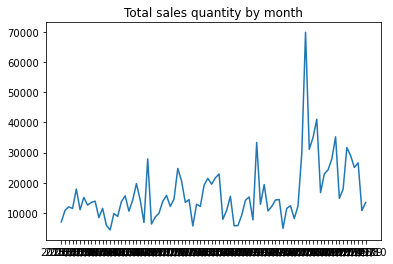

In [26]:
# group by material create a time series for each material for invoiced quantity by month
# diameter_df = reduced_df.groupby(["Diameter"])[["Diameter", "Month", "Invoiced Quantity"]]
# month_df = reduced_df.groupby(["Month"])[["Month", "Invoiced Quantity"]]
date_df = reduced_df.groupby(["Date"], as_index = False)[["Date", "Invoiced Quantity"]].sum()                     

# Prelimiary plot to quickly visualize overall
plt.plot(date_df["Date"], date_df["Invoiced Quantity"])
plt.title("Total sales quantity by month")

plt.show()

In [27]:
# group by year and month then sum invoiced quantity
year_month_df = reduced_df.groupby(["Year", "Month"],
                                   as_index = False)[["Year", "Month", "Invoiced Quantity"]].sum()
year_month_df

,Year,Month,Invoiced Quantity
0,2015,01,7033
1,2015,02,10889
2,2015,03,12035
3,2015,04,11476
4,2015,05,17951
...,...,...,...
77,2021,06,28994
78,2021,07,25092
79,2021,08,26621
80,2021,09,10798


MSE: 23465694.35
MAE: 3503.2166666666667


C:\Users\iamth\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\iamth\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
<ipython-input-88-8aa5445498bd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc1519_df["Forecast"] = ETS(fc1519_df["Invoiced Quantity"],
<ipython-input-88-8aa5445498bd>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

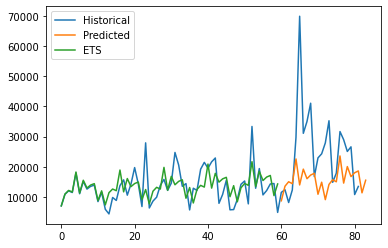

In [88]:
# Holt Winters ETS forecasting

fc_df = year_month_df

fc1519_df = fc_df.loc[(fc_df['Year'] == "2015")|
          (fc_df['Year'] == "2016")|
          (fc_df['Year'] == "2017")|
          (fc_df['Year'] == "2018")|
          (fc_df['Year'] == "2019"), :]

fit_model = ETS(fc1519_df["Invoiced Quantity"],
                           trend="mul",seasonal="mul",
                           seasonal_periods=12).fit()

fc2021 = fit_model.forecast(24).round()

fc1519_df["Forecast"] = ETS(fc1519_df["Invoiced Quantity"],
                           trend="mul",seasonal="mul",
                           seasonal_periods=12).fit().fittedvalues

fc1519_df["Forecast"] = fc1519_df["Forecast"].round()

# plot the forecasted model
fc_df["Invoiced Quantity"].plot(legend=True, label="Historical")
fc2021.plot(legend=True, label="Predicted")
fc1519_df["Forecast"].plot(legend=True, label="ETS")

# mean squared error and mean average error
mse_test = mse(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])
mae_test = meanabs(fc1519_df["Invoiced Quantity"],fc1519_df["Forecast"])

# append forecasted values onto onto model
fc1521_df = pd.DataFrame({"Forecast": fc1519_df["Forecast"].append(fc2021)})

# merge forecasted dataframe with actual sales data frame
fcm_df = fc_df.merge(fc1521_df, how='outer', left_index=True, right_index=True)

fcm_df.at[82,"Year"]= "2021"
fcm_df.at[83,"Year"]= "2021"
fcm_df.at[82,"Month"]= "11"
fcm_df.at[83,"Month"]= "12"

print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")

In [92]:
# Group forecasts by year
fcm_yr_df = fcm_df.groupby(["Year"],
                           as_index = False)[["Year","Invoiced Quantity","Forecast"]].sum()

fcm_yr_df

# fc1519_yr_df

# mse_test = mse(fc1519_yr_df["Invoiced Quantity"],fc1519_yr_df["FC_mul"])
# mae_test = meanabs(fc1519_yr_df["Invoiced Quantity"],fc1519_yr_df["FC_mul"])

# print(f"MSE: {mse_test}")
# print(f"MAE: {mae_test}")

,Year,Invoiced Quantity,Forecast
0,2015,145656.0,149113.0
1,2016,152066.0,154639.0
2,2017,160371.0,161912.0
3,2018,175695.0,170569.0
4,2019,168569.0,177373.0
5,2020,315350.0,184502.0
6,2021,232646.0,192619.0


In [30]:
# Find years and months, 
# create a dataframe containing the summed quantities for each date 
# with months in rows and years in columns

years = year_month_df["Year"].unique()
months = {"Month": year_month_df["Month"].unique()}
yearly_df = pd.DataFrame(months)

for each in years:
    df = year_month_df.loc[year_month_df['Year'] == each]
    df = df[["Month","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    yearly_df = pd.merge(yearly_df, df, on="Month", how="left" )      

yearly_df

,Month,2015,2016,2017,2018,2019,2020,2021
0,01,7033,5910,6349,12896,9199,11519,27922.0
1,02,10889,4379,8625,12168,14199,12394,35276.0
2,03,12035,9826,9919,19219,15306,8156,14860.0
3,04,11476,8848,13838,21474,7709,12339,17904.0
4,05,17951,13763,15824,19552,33378,29773,31690.0
5,06,11066,15669,12179,21651,12894,69930,28994.0
6,07,15160,10593,14596,22923,19419,31108,25092.0
7,08,12611,14253,24757,7888,10685,35025,26621.0
8,09,13517,19745,20615,10848,12128,41086,10798.0
9,10,13919,14311,13531,15516,14318,16750,13489.0


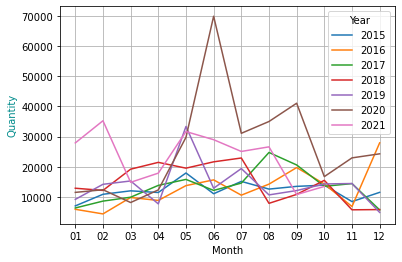

In [31]:
# plot quantity by month for each year
for each in years:
    plt.plot(yearly_df["Month"], yearly_df[each], label = each)

plt.xlabel("Month")
plt.ylabel("Quantity",color = "darkcyan")
plt.legend(title="Year")
plt.grid()
plt.show()

In [32]:
#using .groupby() and .sum() to get the year to invoiced quantity total
combined_year = year_month_df.groupby(['Year'])['Invoiced Quantity'].sum().reset_index()
combined_year

,Year,Invoiced Quantity
0,2015,145656
1,2016,152066
2,2017,160371
3,2018,175695
4,2019,168569
5,2020,315350
6,2021,232646


In [33]:
#dropping year 2020 and 2021 during the covid year before calculating lineregression.
combined_year_drop = combined_year.drop([5,6])
combined_year_drop


,Year,Invoiced Quantity
0,2015,145656
1,2016,152066
2,2017,160371
3,2018,175695
4,2019,168569


The r-squared is: 0.821
y = 6945.5 x + -13848602.1


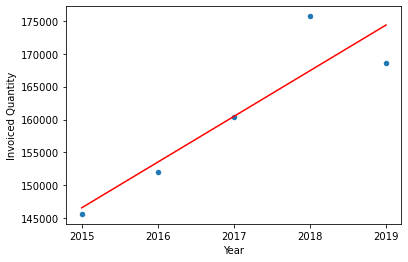

In [34]:
#setting up the linear regression and line for the scatter plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(combined_year_drop["Year"].astype(int),combined_year_drop["Invoiced Quantity"])

#arithmatic for regression
regression_value = combined_year_drop["Year"].astype(int) * slope + intercept
#writing out the linear equation to print into the scatter plot
linear_equ = f"y = {round(slope, 2)} x + {round(intercept, 2)}"

#Plotting the figure and adding the line
combined_year_drop.plot.scatter(x='Year', y='Invoiced Quantity')
plt.plot(combined_year_drop['Year'], regression_value, color='r')

print(f"The r-squared is: {round(rvalue**2,3)}")
print(f"y = {round(slope, 2)} x + {round(intercept, 2)}")
plt.show()

The r-squared is: 0.565
y = 21276.29 x + -42742637.0


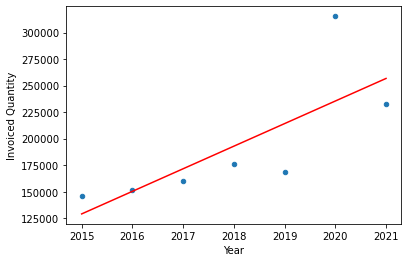

In [35]:
#setting up the linear regression and line for the scatter plot for 7 years including covid
(slope, intercept, rvalue, pvalue, stderr) = linregress(combined_year["Year"].astype(int),combined_year["Invoiced Quantity"])

#arithmatic for regression
regression_value = combined_year["Year"].astype(int) * slope + intercept
#writing out the linear equation to print into the scatter plot
linear_equ = f"y = {round(slope, 2)} x + {round(intercept, 2)}"

#Plotting the figure and adding the line
combined_year.plot.scatter(x='Year', y='Invoiced Quantity')
plt.plot(combined_year['Year'], regression_value, color='r')

print(f"The r-squared is: {round(rvalue**2,3)}")
print(f"y = {round(slope, 2)} x + {round(intercept, 2)}")
plt.show()

In [36]:
application_df = reduced_df.groupby(["Application","Year"],
                                   as_index = False)[["Application","Year","Invoiced Quantity"]].sum()

years = application_df["Year"].unique()
applications = {"Application": application_df["Application"].unique()}
application_year_df = pd.DataFrame(applications)

for each in years:
    df = application_df.loc[application_df['Year'] == each]
    df = df[["Application","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    application_year_df = pd.merge(application_year_df, df, on="Application", how="left" )      

application_year_df

,Application,2015,2016,2017,2018,2019,2020,2021
0,BMX,14526.0,10365.0,8591,6116,4856,7523,6566
1,CYCLOCROSS,1058.0,639.0,1605,1298,1336,893,711
2,DIRT ROAD/GRAVEL,158.0,1257.0,2269,2546,5904,17922,17663
3,DOWNHILL,9902.0,6792.0,6003,9879,7553,13209,8014
4,E BIKE,NaN,NaN,38,47,227,57,28
5,FAT BIKE/PLUS TIRES,4051.0,9196.0,11484,8634,6720,13287,6127
6,HYBRID,3420.0,5142.0,4420,4441,1851,974,1735
7,MODIFIED TRIALS,183.0,193.0,177,134,213,277,310
8,MOUNTAIN,95255.0,103177.0,114649,127527,122379,238279,169624
9,ROAD,9599.0,8930.0,3811,3873,4479,6622,3942


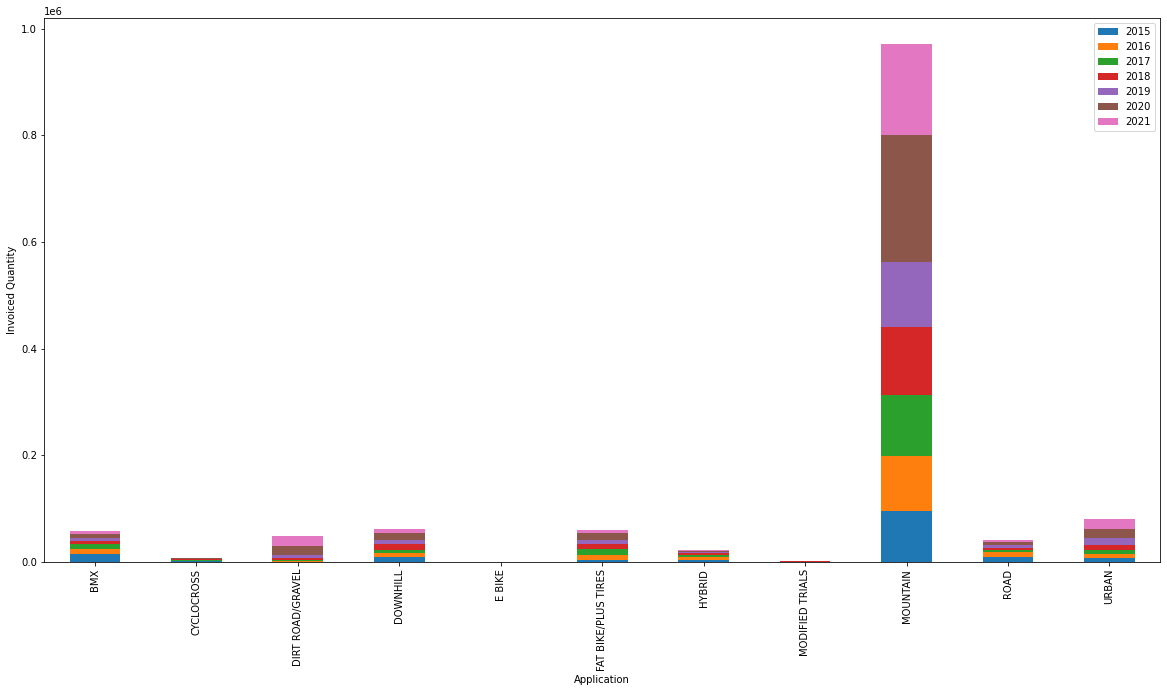

In [37]:
application_year_df.set_index("Application").plot(kind='bar',figsize=(20,10), stacked = True)

plt.xlabel('Application')
plt.ylabel('Invoiced Quantity')

plt.legend(['2015',
            '2016',
            '2017',
            '2018',
            '2019',
            '2020',
            '2021',
           ])

plt.show()

In [38]:
diameter_df = reduced_df.groupby(["Application","Diameter","Year"],
                                   as_index = False)[["Application","Diameter","Year",
                                                      "Invoiced Quantity"]].sum()

diameter_mountain_df = diameter_df.loc[diameter_df['Application'] == "MOUNTAIN"]

diameter_mountain_df = diameter_mountain_df[["Diameter","Year","Invoiced Quantity"]]

years = diameter_mountain_df["Year"].unique()
diameters = {"Diameter": diameter_mountain_df["Diameter"].unique()}
diameter_year_df = pd.DataFrame(diameters)

for each in years:
    df = diameter_mountain_df.loc[diameter_mountain_df['Year'] == each]
    df = df[["Diameter","Invoiced Quantity"]]
    df = df.rename(columns={"Invoiced Quantity" : each})
    diameter_year_df = pd.merge(diameter_year_df, df, on="Diameter", how="left" )      

diameter_year_df

,Diameter,2015,2016,2017,2018,2019,2020,2021
0,24,496,574,481,918,1720,4499,2375
1,26,20255,20818,9277,8314,9522,13362,5849
2,27.5,29671,40405,47500,49531,44642,78576,42606
3,29,44833,41380,57391,68764,66495,141842,118794


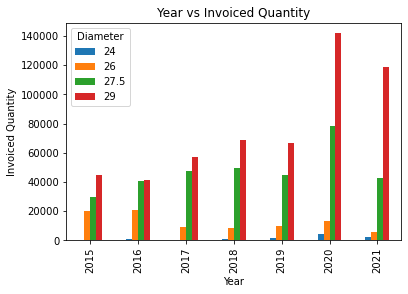

In [39]:
# plot quantity by diameter for each year
#for each in years:
    #plt.plot(diameter_year_df["Diameter"], diameter_year_df[each], label = each)
# diameter_year_df = diameter_year_df.astype(float)
# diameter_year_df.transpose().plot(kind='bar')

diameter_year_df.set_index("Diameter").transpose().plot(kind='bar')

plt.xlabel('Year')
plt.ylabel('Invoiced Quantity')
plt.title('Year vs Invoiced Quantity')
plt.show()

In [40]:
#Percent change usind .pct_change()
pct_chng_diameter = diameter_year_df.set_index("Diameter").transpose().pct_change().fillna(0)
pct_chng_diameter

Diameter,24,26,27.5,29
2015,0.000000,0.000000,0.000000,0.000000
2016,0.157258,0.027796,0.361767,-0.077019
2017,-0.162021,-0.554376,0.175597,0.386926
2018,0.908524,-0.103805,0.042758,0.198167
2019,0.873638,0.145297,-0.098706,-0.032997
2020,1.615698,0.403277,0.760136,1.133123
2021,-0.472105,-0.562266,-0.457773,-0.162491


Text(0.5, 1.0, 'Year vs Percent Change in Quantity')

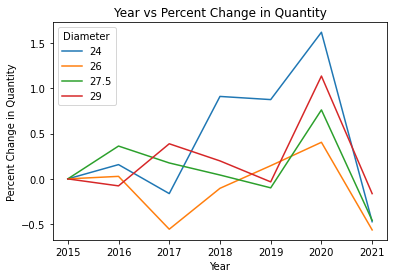

In [41]:
#figure of percent change
pct_chng_diameter.plot()
plt.xlabel('Year')
plt.ylabel('Percent Change in Quantity')
plt.title('Year vs Percent Change in Quantity')

In [42]:
#chi testing data from combined_year
observed_df = [164289,166147,182019,180908]
expected_df = [161178,164289,166147,182019]


chi = {'year': ['2016', '2017', '2018', '2019', '2020','2021'],
         'observed': [164289,166147,182019,180908,338662,242501], 'expected':[161178,164289,166147,182019,180908,338662]
        }

chi_df = pd.DataFrame(chi)

chi_df


,year,observed,expected
0,2016,164289,161178
1,2017,166147,164289
2,2018,182019,166147
3,2019,180908,182019
4,2020,338662,180908
5,2021,242501,338662


In [43]:
critical_value = st.chi2.ppf(q = 0.95, df = 2)

In [44]:
critical_value

5.991464547107979

In [45]:
st.chisquare(chi_df['observed'], chi_df['expected'])

Power_divergenceResult(statistic=166471.84555632347, pvalue=0.0)